### Exploring Audio Features and building a Machine Learning Approach

# A Music Taste Analysis Using Spotify API and Python.

A few days back we were chilling in our hostel room, where we would often play a collaborative playlist so that everyone gets a chance and it struck me, how compatible our music tastes are? Because often the songs played by one of us was appreciated by the other two but as Engineer I needed to prove facts to state this truth. As a Data Scientist the first question that struck my mind was how to get the music meta data and some SVM models started to build up intuitively. Taking the same idea forward I came across these amazing Spotify APIs that had almost everything I needed and even more all I had to do was a few API calls and ofcourse the Authorization. But to keep it simple I asked for their Spotify playlist URIs and used SPotify APIs to scrap their playlists and mine as well and here we are! 

## Tools 
* Spotipy Library to get access to Spotify platform music data 
* Seaborn and matplotlib for data visualization
* Pandas and numpy for data analysis
* sklearn to build the Machine Learning model


# Spotify Audio Features


It's important to mention that I did not use all of the 16 columns for the analysis. Instead, I selected only those columns related to the audio features. You can find below the explanation of each feature ( past/copy from Spotify website).

* Acousticness : A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.

* Danceability : Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

* Energy : Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy. 

* Instrumentalness: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0. 

* Liveness: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.

* Loudness: he overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

* Speechiness: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks. 

* Valence: A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry). 

* Tempo: The overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration. 

In [1]:
#Import Libraries
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn import svm
%matplotlib inline


In [2]:
#dataframe shape
df_amaya = pd.read_csv(r'data\Amaya_playlist.csv')
df_amaya.shape

(100, 17)

In [3]:
#Load all sheets into a dictionary of dataframes and then concatenate all the values in the dictionary into one dataframe. 
df_shashwat = pd.read_csv(r'data\Shashwat_playlist.csv')
#Concatenate all dataframes
#df_shashwat = pd.concat(dict_shashwat.values())

In [4]:
#Check all rows
pd.set_option('display.max_rows', None)

In [5]:
# Shashwat dataframe
df_shashwat.reset_index(inplace=True)
df_shashwat.head(3)

,index,Unnamed: 0,id,title,first_artist,all_artists,danceability,energy,key,loudness,mode,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,0,5mEMOGsjp1Jhn2l0Yt1p3V,Savan,Vilen,['Vilen'],0.609,0.401,4,-12.281,1,0.530000,0.02350,0.7160,0.373,79.986,233273,4
1,1,1,4NEdR5Yo8D2KwL7Y9KW7EH,Mere Gully Mein (feat. Naezy),DIVINE,"['DIVINE', 'Naezy']",0.744,0.813,9,-7.401,1,0.000514,0.00000,0.0685,0.149,108.056,182934,4
2,2,2,5b4bjAPxGu2yS2b8IQpY39,Tu Na Mera,Arjun Kanungo,['Arjun Kanungo'],0.460,0.562,1,-6.830,1,0.832000,0.00002,0.1220,0.463,84.020,221020,4


In [6]:
#Drop index column
#df_shashwat = df_shashwat.drop('index', axis= 1)
df_shashwat = df_shashwat.drop('Unnamed: 0', axis= 1)

In [7]:
# Columns
df_shashwat.columns

Index(['index', 'id', 'title', 'first_artist', 'all_artists', 'danceability',
       'energy', 'key', 'loudness', 'mode', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature'],
      dtype='object')

In [8]:
#df_shashwat.set_index('index', inplace=True)
df_amaya.head(3)
df_amaya = df_amaya.drop('Unnamed: 0', axis= 1)

# Data Set Balancing

As we can see below, we have way more songs in my list.So, in order to have a fair comparison between the data sets, we have to balance both of them. To do that, let's create a for loop that goes through my dataframe and randomly drops some rows of the most frequently occurring artists. 

In [9]:
# Total of rows - amaya
df_amaya.first_artist.count()

100

In [10]:
# Total of rows - shashwat
df_shashwat.first_artist.count()

100

Balance the numbers of songs


In [11]:
# Create a dictionary in which the keys are the artists of my list and the values are the total of songs for each singer or group.
my_dict = dict(df_amaya.first_artist.value_counts())
my_dict

{'Prateek Kuhad': 14,
 'The Local Train': 9,
 'Mohit Chauhan': 5,
 'Ritviz': 4,
 'When Chai Met Toast': 3,
 'Lauv': 2,
 'Clinton Cerejo': 2,
 'Ankur Tewari': 2,
 'Flume': 2,
 'Vilen': 2,
 'Dehlvees': 2,
 'Rashid Ali': 2,
 'Ali Tariq': 1,
 'Bryan Adams': 1,
 'One Direction': 1,
 'Ram Sampath': 1,
 'Imagine Dragons': 1,
 'Taba Chake': 1,
 'Mohan Kanan': 1,
 'Dominique': 1,
 'Harrdy Sandhu': 1,
 'Karthik': 1,
 'RISH': 1,
 'Vishal-Shekhar': 1,
 'Rahat Fateh Ali Khan': 1,
 'Dream Note': 1,
 'Amitabh Bhattacharya': 1,
 'Hans Raj Hans': 1,
 'Troye Sivan': 1,
 'The Japanese House': 1,
 'Ali Zafar': 1,
 'KK': 1,
 'Umer Farooq': 1,
 'Enrique Iglesias': 1,
 'Midival Punditz': 1,
 'John Legend': 1,
 'Palash Sen': 1,
 'Michael Jackson': 1,
 'Zaeden': 1,
 'Vaibhav Malhotra': 1,
 'Lucky Ali': 1,
 'MEMBA': 1,
 'Karthik Rao': 1,
 'Zack Knight': 1,
 'Bhuvan Bam': 1,
 'Tore Bojsten': 1,
 'Smrtdeath': 1,
 'A.R. Rahman': 1,
 'Neeraj Shridhar': 1,
 'Conan Gray': 1,
 'Sunil Kamath': 1,
 'Shankar Mahadevan': 

In [12]:
# Create a temporary subset
temp_subset = df_amaya

In [13]:
for k,v in my_dict.items(): 
    if v > 200 :
        drop_rows = 150
        drop_indexes_array = df_amaya[df_amaya.first_artist == k].sample(n = drop_rows).index
        temp_subset = temp_subset.drop(drop_indexes_array)
    elif v == 143 or v == 133 or v == 134:
        drop_rows = 60
        drop_indexes_array = df_amaya[df_amaya.first_artist == k].sample( n = drop_rows).index
        temp_subset = temp_subset.drop(drop_indexes_array)
    elif v ==178:
        drop_rows = 100
        drop_indexes_array = df_amaya[df_amaya.first_artist == k].sample(n = drop_rows).index
        temp_subset = temp_subset.drop(drop_indexes_array)

df_amaya = temp_subset

In [14]:
#Balanced dataframe
df_amaya.first_artist.count()

100

In [15]:
# Setting new column to identify the users
df_amaya['who'] = 1
df_shashwat['who'] = 0

In [16]:
# Combine both data frames 
df_friends = df_amaya.append(df_shashwat)
df_friends.reset_index(inplace= True)
df_friends.drop('index', axis = 1, inplace= True)
df_friends.head(3)

,level_0,acousticness,all_artists,danceability,duration_ms,energy,first_artist,id,instrumentalness,key,liveness,loudness,mode,tempo,time_signature,title,valence,who
0,0,0.0367,['Michael Jackson'],0.608,297400,0.816,Michael Jackson,541jTq3SOEELKvcfA0jHI0,0.000554,1,0.116,-5.926,1,114.484,4,The Way You Make Me Feel,0.507,1
1,1,0.3810,['Swastik The Band'],0.602,349922,0.564,Swastik The Band,0utckWY4eeZAfNL3LCiGdy,0.132000,4,0.118,-6.164,0,129.973,4,Main Chahta hun,0.189,1
2,2,0.5280,['Prateek Kuhad'],0.751,235932,0.344,Prateek Kuhad,3FTRSa9mWB3kKx2jkhUAN3,0.000002,6,0.113,-7.712,1,122.100,3,Tum Jab Paas,0.471,1


# Mean values of The Audio Features

In [17]:
# Create data frame with features
def features(df,who):
    if who == 'both':
         features = df.loc[: ,['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence', 'who']]         
    elif who == 0 or who == 1:   
          features = df.loc[df.who == who,['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'speechiness', 'valence']]           
    else:
        return 'Error'
    return features

In [18]:
features_amaya = features(df_friends, 1)
features_shashwat = features(df_friends,0)
features_amaya.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence
0,0.0367,0.608,0.816,0.000554,0.116,NaN,0.507
1,0.3810,0.602,0.564,0.132000,0.118,NaN,0.189
2,0.5280,0.751,0.344,0.000002,0.113,NaN,0.471
3,0.0150,0.362,0.763,0.004810,0.237,NaN,0.431
4,0.8670,0.762,0.391,0.000521,0.112,NaN,0.355


In [19]:
df_shashwat.first_artist.value_counts()

The Local Train        12
Prateek Kuhad           9
Ritviz                  7
Vidya Vox               6
Vilen                   5
When Chai Met Toast     5
Jasleen Royal           4
Parekh & Singh          3
DIVINE                  2
Dehlvees                2
Taba Chake              2
Bhuvan Bam              2
The Yellow Diary        2
Anuv Jain               2
Ankur Tewari            2
Swastik The Band        2
Shamoon Ismail          1
RISH                    1
Vayu                    1
Fotty Seven             1
Ami Mishra              1
Prabh Deep              1
Ashwin Adwani           1
Punjabi Tracks          1
Lifafa                  1
Kurt Hugo Schneider     1
Ankit Tiwari            1
Umer Farooq             1
Arjun Kanungo           1
Shah Rule               1
Swanand Kirkire         1
Karthik Rao             1
Dino James              1
VILEN                   1
Bilal Saeed             1
Dream Note              1
Rupinn                  1
Anushka Shahaney        1
Shlok Chiplu

In [20]:
df_amaya.first_artist.value_counts()

Prateek Kuhad           14
The Local Train          9
Mohit Chauhan            5
Ritviz                   4
When Chai Met Toast      3
Lauv                     2
Clinton Cerejo           2
Ankur Tewari             2
Flume                    2
Vilen                    2
Dehlvees                 2
Rashid Ali               2
Ali Tariq                1
Bryan Adams              1
One Direction            1
Ram Sampath              1
Imagine Dragons          1
Taba Chake               1
Mohan Kanan              1
Dominique                1
Harrdy Sandhu            1
Karthik                  1
RISH                     1
Vishal-Shekhar           1
Rahat Fateh Ali Khan     1
Dream Note               1
Amitabh Bhattacharya     1
Hans Raj Hans            1
Troye Sivan              1
The Japanese House       1
Ali Zafar                1
KK                       1
Umer Farooq              1
Enrique Iglesias         1
Midival Punditz          1
John Legend              1
Palash Sen               1
M

In [21]:
amaya_total_songs = df_amaya.first_artist.count()
shashwat_total_songs = df_shashwat.first_artist.count()
print(f'Total of songs:\nAmaya: {df_amaya.first_artist.count()}\nShashwat:{df_shashwat.first_artist.count()}')

Total of songs:
Amaya: 100
Shashwat:100


# Data Analysis

I will commence by plotting a Bar chart and a Radar Chart showing the means of our features in order to compare both of them. 

The plots show that the predominant feature in my list of artists is **danceability** - probably because of upbeat music such as Ritviz, The Local Train and Naalayak. On the other hand, looking at Shashwat's features, we can notice that even his predominant feature is **danceability**. That really makes sense since we both are hardcore indies fan and listen to almost same artists and music. As we can see from the bar charts other features are also close such as acousticness, energy, valence and even instrumentalness, my god I had expected a close score but this is scary! :P 

We can also conclude from the charts that I listen to more acoustic songs than Shashwat because I'm more like into songwriter feels like Prateek Kuhad and such on the other hand Shashwat listens to more energy and danceable songs then me as he is partially into EDM too. Woah! I'm proving music behaviour of a person by codes, this is exciting! *_*

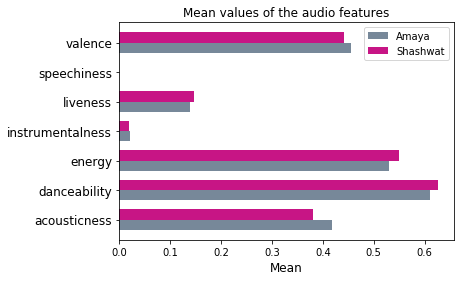

In [22]:
# Number of features
N = len(features_amaya.mean())
# Array with the number of features
ind = np.arange(N) 

width = 0.35  
#Bar plot with my list
plt.barh(ind, features_amaya.mean() , width, label='Amaya', color = 'lightslategray')
#Bar plot with her list
plt.barh(ind + width, features_shashwat.mean(), width, label='Shashwat', color = 'mediumvioletred')

#X- label
plt.xlabel('Mean', fontsize = 12)
# Title
plt.title('Mean values of the audio features')
#Vertical ticks
plt.yticks(ind + width / 2, (list(features_shashwat)[:]), fontsize = 12)
#legend
plt.legend(loc='best')
# Figure size
plt.rcParams['figure.figsize'] =(8,8)
# Set style
style.use("ggplot")
plt.savefig(r"C:\Users\hp\Downloads\Feature_Similarity_AmayaVSShashwat.png")
plt.show()




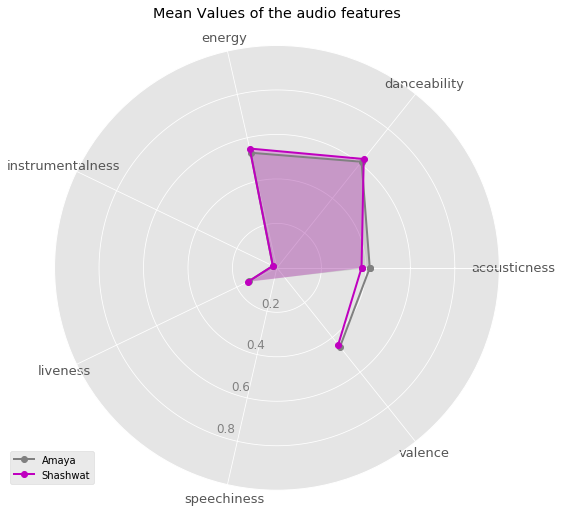

In [23]:

import matplotlib.pyplot as plt
labels= list(features_amaya)[:]
stats= features_amaya.mean().tolist()
stats2 = features_shashwat.mean().tolist()

angles=np.linspace(0, 2*np.pi, len(labels), endpoint=False)

# close the plot
stats=np.concatenate((stats,[stats[0]]))
stats2 =np.concatenate((stats2,[stats2[0]])) 
angles=np.concatenate((angles,[angles[0]]))

#Size of the figure
fig=plt.figure(figsize = (18,18))

ax = fig.add_subplot(221, polar=True)
ax.plot(angles, stats, 'o-', linewidth=2, label = "Amaya", color= 'gray')
ax.fill(angles, stats, alpha=0.25, facecolor='gray')
ax.set_thetagrids(angles * 180/np.pi, labels , fontsize = 13)


ax.set_rlabel_position(250)
plt.yticks([0.2 , 0.4 , 0.6 , 0.8  ], ["0.2",'0.4', "0.6", "0.8"], color="grey", size=12)
plt.ylim(0,1)

ax.plot(angles, stats2, 'o-', linewidth=2, label = "Shashwat", color = 'm')
ax.fill(angles, stats2, alpha=0.25, facecolor='m' )
ax.set_title('Mean Values of the audio features')
ax.grid(True)

plt.legend(loc='best', bbox_to_anchor=(0.1, 0.1))
plt.savefig(r"C:\Users\hp\Downloads\Mean_Feature_Similarilty_AmayaVSShashwat.png")



The tempo is an important feature in terms of music analysis. It can be as significant as melody, harmony or rhythm due to the fact that it represents the speed of a song and the mood it evokes. For instance, the higher the BPM of a song, the faster the song is and consequently more inspiring and joyful it tends to be. On the other hand, a low BPM means that the song is slower, which can indicate sadness, romance or drama. 


Looking at the graph below we can see that my tempo on average is around 113BPM as I'm more into acoustic music which is usually slow, romantic and soothing whereas for Shashwat it is 120BPM which again proves the earlier stated fact that he likes songs with upbeats such as EDM more when compared to me. 

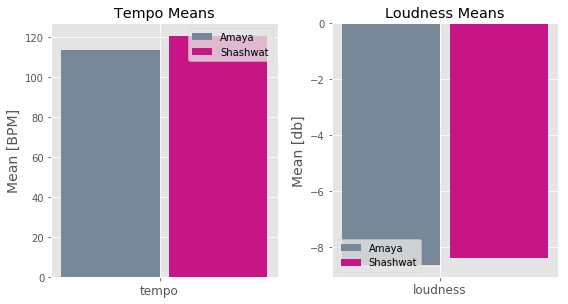

<Figure size 864x936 with 0 Axes>

In [24]:
tempo_shashwat = df_friends.loc[ df_friends.who == 0, ['tempo']]
tempo_amaya = df_friends.loc[ df_friends.who == 1, ['tempo']]

N = len(tempo_shashwat.mean())

ind = np.arange(N) 

plt.subplot(221)
width = 0.35      
plt.bar(ind, tempo_amaya.mean() , width, label='Amaya', color = 'lightslategray')
plt.bar(ind + 1.1*width, tempo_shashwat.mean(), width, label='Shashwat', color = 'mediumvioletred')

plt.ylabel('Mean [BPM]', fontsize = 14)
plt.title('Tempo Means')

plt.xticks(ind + width / 2, (list(tempo_shashwat)[:]), fontsize = 12)
plt.legend(loc='best')
style.use("ggplot")


plt.subplot(222)

loud_shashwat = df_friends.loc[ df_friends.who == 0, ['loudness']]
loud_amaya = df_friends.loc[ df_friends.who == 1, ['loudness']]

N = len(loud_shashwat.mean())

ind = np.arange(N) 

width = 0.35      
plt.bar(ind, loud_amaya.mean() , width, label='Amaya', color = 'lightslategray')
plt.bar(ind + 1.1*width, loud_shashwat.mean(), width, label='Shashwat', color = 'mediumvioletred')

plt.ylabel('Mean [db]', fontsize = 14)
plt.title('Loudness Means')



plt.xticks(ind + width / 2, (list(loud_shashwat)[:]), fontsize = 12)
plt.legend(loc='lower left')
style.use("ggplot")
plt.rcParams['figure.figsize'] =(12,13)
plt.tight_layout()
plt.show()
plt.savefig(r"C:\Users\hp\Downloads\Temp_LOudness_AmayaVSShashwat.png")

In [25]:
tempo_shashwat.mean()

tempo    120.75719
dtype: float64

In [26]:
tempo_amaya.mean()

tempo    113.75392
dtype: float64

## How diversified are the lists ?!

The variety of the lists can be investigated by checking the difference in genres of our songs. In our case most of the songs belong to the same genre we would say that we are low varied.

The question is: How would we analyze this ? well, the answer is simple : Let's check the standard deviation of each audio variable and examine them. 

Although the standard deviation of the audio features themselves do not give us much information ( as we can see in the plots below), we can sum them up and calculate the mean of the standard deviation of the lists. By doing that we get the values represented in the plot "Variety of Audio Features" with values of **0.16 in **my list and **0.16 in** Emily's list.

How would we interpret that?! Well, let's say we can have songs with a same value of a specific feature such as energy, acousticness, danceability, etc. In short, those numbers suggest we both have equally diversified songs i.e. we both explore around looking for a same kind of sound.

In [27]:
round(features_amaya.std().mean(),2)

0.16

In [28]:
round(features_shashwat.std().mean(),2)

0.16

In [29]:
features_amaya.std().mean()

0.16096208813173704

In [30]:
features_shashwat.std().mean()

0.15953406202238196

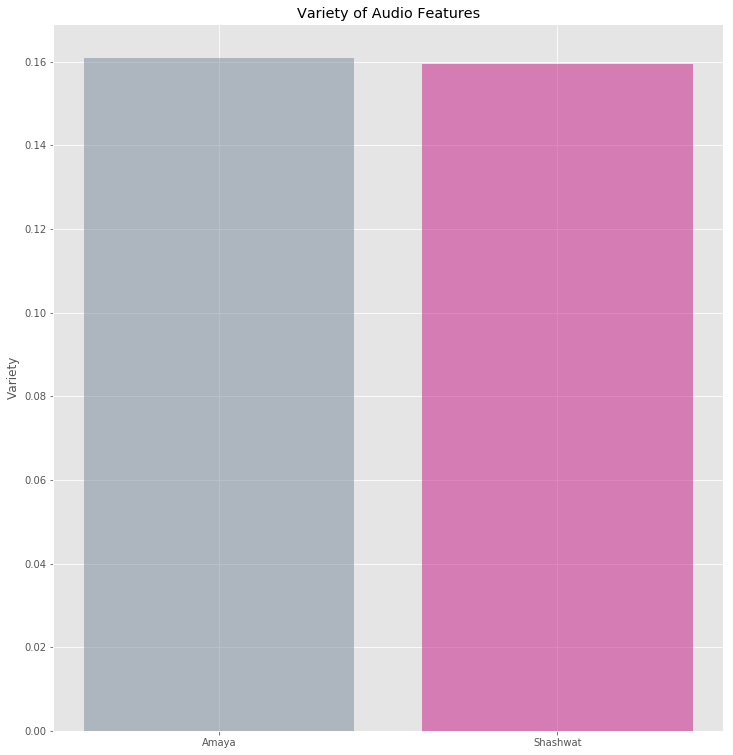

In [31]:
data = [features_amaya.std().mean(), features_shashwat.std().mean()]
names = ('Amaya','Shashwat')
pos = np.arange(len(names))
colors = ['lightslategray', 'mediumvioletred']

plt.bar(pos, data, align = 'center', alpha = 0.5, color = colors)
plt.xticks(pos, names)
plt.ylabel('Variety')
plt.title('Variety of Audio Features')
plt.show()


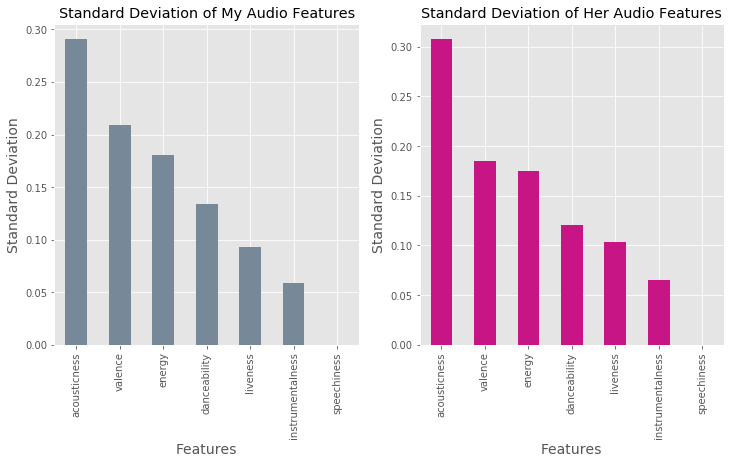

In [32]:
plt.subplot(221)

features_amaya.std().sort_values(ascending= False).plot(kind = 'bar', color = 'lightslategray')

plt.xlabel('Features', fontsize = 14)
plt.ylabel('Standard Deviation', fontsize = 14)
plt.title("Standard Deviation of My Audio Features")

plt.subplot(222)
features_shashwat.std().sort_values(ascending= False).plot(kind = 'bar', color = 'mediumvioletred')

plt.xlabel('Features', fontsize = 14)
plt.ylabel('Standard Deviation', fontsize = 14)
plt.title("Standard Deviation of Her Audio Features")
plt.rcParams['figure.figsize'] =(15,15)


In [33]:
features_friends = features(df_friends, who = 'both')
features_friends.head()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,valence,who
0,0.0367,0.608,0.816,0.000554,0.116,NaN,0.507,1
1,0.3810,0.602,0.564,0.132000,0.118,NaN,0.189,1
2,0.5280,0.751,0.344,0.000002,0.113,NaN,0.471,1
3,0.0150,0.362,0.763,0.004810,0.237,NaN,0.431,1
4,0.8670,0.762,0.391,0.000521,0.112,NaN,0.355,1


## Correlation Between Variables

we can also build correlation plots , such as scatter plots, to show the relationship between variables. In our case, we will correlate the feature valence which describes the musical positiveness with danceability and energy. 

In order to interpret the plots below, we have to keep in mind that numbers one ( green dots) and zero (gray dots) represent mine and Shashwat's songs, respectively. That said, let's check the scatter plots.

### Valence and Energy


The correlation between valence and energy shows us that there is a conglomeration of songs with high energy and a low level of valence. This means that many of my energetic songs sound more negative with feelings of sadness, anger and depression ( Lo-Fi raps takes special place here haha). whereas when we look at the grays dots we can see that as the level of valence - positive feelings increase, the energy of the songs also increases. Although his data is split , we can identify this pattern which indicates a kind of 'linear' correlation between the variables.

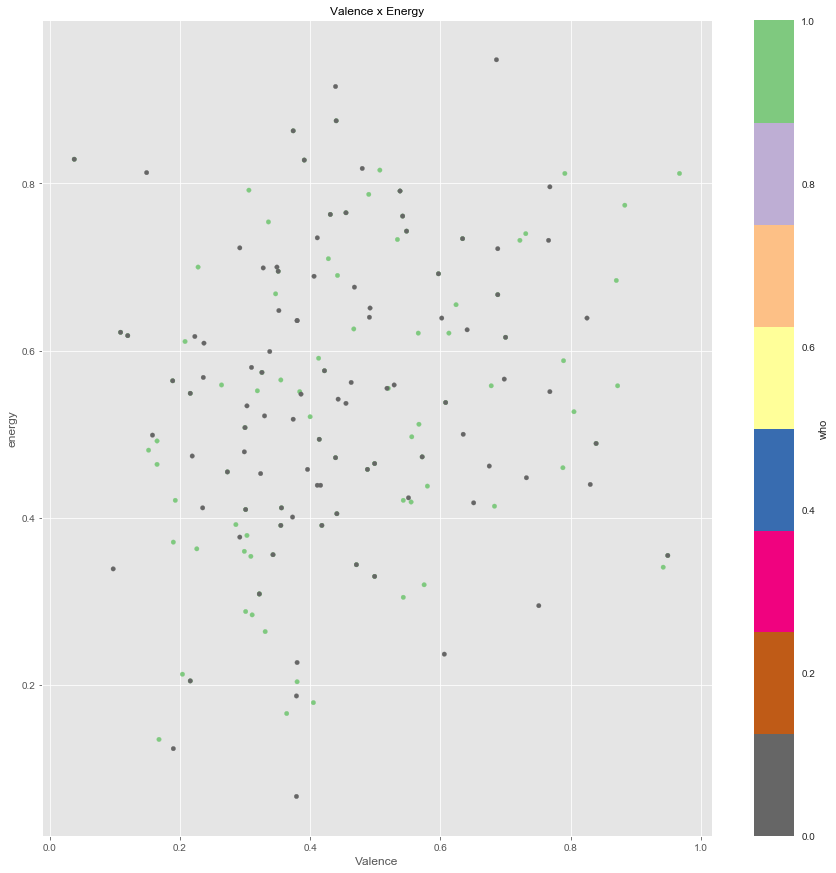

In [34]:
fig, ax = plt.subplots()
style.use('seaborn')
df_friends.plot(kind='scatter',x='valence', y='energy',ax = ax ,c='who', colormap = 'Accent_r' ,title="Valence x Energy")
ax.set_xlabel("Valence")
plt.show()

# Valence and Danceability

Now, looking at the relationship between valence and danceability we can see that Shashwat's songs have slightly high values of danceability throughout. On the other hand, my songs are mostly low valence and a medium danceability which is what actually define acoustic music where we can like do a little slow dance but focus on the lyrics and let it in as well.

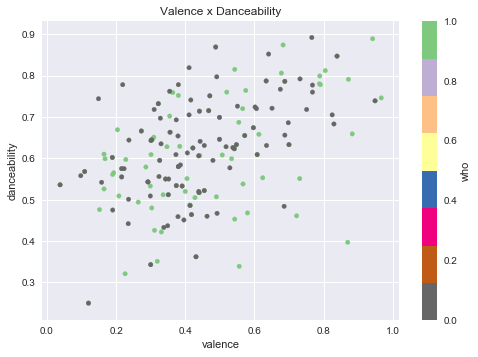

In [35]:
fig,ax = plt.subplots()
df_friends.plot(kind = 'scatter', x = 'valence', y = 'danceability', c = 'who',ax = ax, colormap = 'Accent_r', title = 'Valence x Danceability')
plt.show()

## The Machine Learning Approach

Ok, we've got some insights from the data. In order to keep this article short, let's jump right into the best part (at least to me) which is the machine learning (ML) algorithm.

It's important to bear in mind that I'm not 100% focused on the accuracy of the model. Besides, we will be using a Support Vector Machine (svm). In addition, I won't explain how svm works. Instead, let's say that it is a supervised ML approach which is used for both classification and regression problems. Also, it's main task (classification) is to separate all the classes by defining an optimal hyperplane that discriminates them. That being said, let's build an algorithm to predict if a song is more likely to belong to my list or Shashwat's.

### Removing Features

The first step is to preprocess our data set in order to have a dataframe with numerical values in all of the columns. So let's start off dropping all features which are not relevant to our model such as id, album, name, uri, popularity and track_number and separate the target (who column) from our dataframe. We can easily do that by building the function features_removal which receives a list with the features we want to drop as a parameter.

Notice that after its removal, we still have a categorical feature (**artist**). So, we'll have to deal with that in the second step. Also, important to mention that we have two balanced classes (column who) which indicate whose list the song belongs to. In short, there are 100 songs in my list and 100 in his list and, that balance, in terms of quantity is important to our model.



In [36]:
df_friends.head(3)

,level_0,acousticness,all_artists,danceability,duration_ms,energy,first_artist,id,instrumentalness,key,liveness,loudness,mode,tempo,time_signature,title,valence,who
0,0,0.0367,['Michael Jackson'],0.608,297400,0.816,Michael Jackson,541jTq3SOEELKvcfA0jHI0,0.000554,1,0.116,-5.926,1,114.484,4,The Way You Make Me Feel,0.507,1
1,1,0.3810,['Swastik The Band'],0.602,349922,0.564,Swastik The Band,0utckWY4eeZAfNL3LCiGdy,0.132000,4,0.118,-6.164,0,129.973,4,Main Chahta hun,0.189,1
2,2,0.5280,['Prateek Kuhad'],0.751,235932,0.344,Prateek Kuhad,3FTRSa9mWB3kKx2jkhUAN3,0.000002,6,0.113,-7.712,1,122.100,3,Tum Jab Paas,0.471,1


In [37]:
# Remove columns
def features_removal(features_list):
    for i in features_list:
        df_friends.drop(i, axis = 1, inplace = True)
    return ';)'

In [38]:
# Apply function
features_removal(['id', 'name', 'popularity', 'track_number', 'uri'])
df_friends.head(3)

KeyError: "['name'] not found in axis"

In [39]:
df_friends.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 17 columns):
level_0             200 non-null int64
acousticness        200 non-null float64
all_artists         200 non-null object
danceability        200 non-null float64
duration_ms         200 non-null int64
energy              200 non-null float64
first_artist        200 non-null object
instrumentalness    200 non-null float64
key                 200 non-null int64
liveness            200 non-null float64
loudness            200 non-null float64
mode                200 non-null int64
tempo               200 non-null float64
time_signature      200 non-null int64
title               200 non-null object
valence             200 non-null float64
who                 200 non-null int64
dtypes: float64(8), int64(6), object(3)
memory usage: 26.6+ KB


In [40]:
#Remove who column from our data set
target = df_friends['who']
df_friends.drop('who', axis = 1, inplace = True)

In [41]:
target.head()

0    1
1    1
2    1
3    1
4    1
Name: who, dtype: int64

In [42]:
# Notice that we have a slightly balanced data
target.value_counts()

1    100
0    100
Name: who, dtype: int64

In [43]:
df_friends.head()

,level_0,acousticness,all_artists,danceability,duration_ms,energy,first_artist,instrumentalness,key,liveness,loudness,mode,tempo,time_signature,title,valence
0,0,0.0367,['Michael Jackson'],0.608,297400,0.816,Michael Jackson,0.000554,1,0.116,-5.926,1,114.484,4,The Way You Make Me Feel,0.507
1,1,0.3810,['Swastik The Band'],0.602,349922,0.564,Swastik The Band,0.132000,4,0.118,-6.164,0,129.973,4,Main Chahta hun,0.189
2,2,0.5280,['Prateek Kuhad'],0.751,235932,0.344,Prateek Kuhad,0.000002,6,0.113,-7.712,1,122.100,3,Tum Jab Paas,0.471
3,3,0.0150,['Prateek Kuhad'],0.362,216886,0.763,Prateek Kuhad,0.004810,3,0.237,-8.514,1,187.291,4,Tune Kaha,0.431
4,4,0.8670,"['Ankur Tewari', 'Prateek Kuhad', 'Dhruv Bhola...",0.762,250000,0.391,Ankur Tewari,0.000521,1,0.112,-11.735,1,137.956,3,"Dil Beparvah - The Dewarists, Season 5",0.355


### Label Encoder

The second task is to transform all categocal data (artists names) into numeric data. Why do we have to do that? Well, the ML algorithm only accepts numerical data, hence, the reason why we have to use the class LabelEncoder to encode each artist name into a specific number. The encoding process is shown below.


In [44]:
# Import LabelEncode
from sklearn.preprocessing import LabelEncoder

In [45]:
# LabelEncoder obj 
enc = LabelEncoder()

In [46]:
# Set Labels
artist_label = enc.fit_transform(df_friends.first_artist)

In [47]:
#Create column containin the labels
df_friends['labels_artists'] = artist_label

In [48]:
#Remove colum artist (cathegorical data)
features_removal(['first_artist'])

';)'

In [49]:
# DataFrame
df_friends.sample(10)

,level_0,acousticness,all_artists,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,tempo,time_signature,title,valence,labels_artists
76,76,0.3590,['Mohan Kanan'],0.526,212168,0.464,0.001670,7,0.1170,-7.767,1,141.934,4,Kinare,0.165,43
185,85,0.4790,['The Yellow Diary'],0.433,222579,0.599,0.000002,9,0.1200,-7.293,1,71.798,4,Marz,0.338,77
107,7,0.4180,['Ritviz'],0.683,186667,0.440,0.000000,0,0.4380,-7.080,1,99.050,4,Jeet 2.0,0.830,58
153,53,0.0206,['Vidya Vox'],0.520,205118,0.916,0.001010,0,0.0846,-3.616,0,119.991,3,Kuthu Fire,0.439,84
191,91,0.1680,['When Chai Met Toast'],0.644,202600,0.609,0.009710,11,0.2250,-6.442,1,107.022,4,Run Closer,0.237,87
113,13,0.1470,['Vilen'],0.645,224040,0.534,0.000004,4,0.0858,-5.428,0,90.025,4,Ek Raat,0.303,85
165,65,0.3280,['Mohit Chauhan'],0.609,321225,0.538,0.000000,6,0.1250,-7.842,1,130.007,4,Tum Se Hi,0.608,44
97,97,0.3920,['Vilen'],0.739,185000,0.355,0.002180,5,0.0996,-9.618,0,174.055,4,Rataan,0.949,85
60,60,0.8870,['Prateek Kuhad'],0.468,210420,0.438,0.368000,3,0.1140,-14.575,1,76.139,4,100 words,0.580,51
3,3,0.0150,['Prateek Kuhad'],0.362,216886,0.763,0.004810,3,0.2370,-8.514,1,187.291,4,Tune Kaha,0.431,51


In [50]:
df_friends.labels_artists.value_counts()

51    23
76    21
58    11
87     8
85     7
44     6
84     6
6      4
19     4
30     4
49     3
74     3
73     3
12     3
77     3
48     2
88     2
17     2
25     2
39     2
53     2
22     2
56     2
57     2
34     2
18     2
16     2
11     2
80     2
8      2
36     2
14     1
27     1
1      1
33     1
2      1
32     1
31     1
3      1
29     1
4      1
28     1
26     1
13     1
15     1
35     1
7      1
20     1
24     1
9      1
23     1
10     1
21     1
5      1
89     1
37     1
72     1
66     1
67     1
68     1
69     1
70     1
71     1
75     1
64     1
78     1
79     1
81     1
82     1
83     1
86     1
65     1
63     1
38     1
47     1
40     1
41     1
42     1
43     1
45     1
46     1
50     1
62     1
52     1
54     1
55     1
59     1
60     1
61     1
0      1
Name: labels_artists, dtype: int64

## Pipeline

Now that we have our data set almost ready we can build our model. You might be wondering : almost ready ?! Well, when we are dealing with some ML algorithms we have to keep in mind that some of them expect data in a specific range or structure. For instance, sometimes we have to transform our data into a higher dimension in order to find the boundary that separates the classes as can be seen in the figure below. To accomplish that, we use a technique called kernel trick which offers an efficient and less expensive way to do this mapping. In addition, it uses different functions ( kernel) for that and the most popular ones are polynomial, linear and radial basis function (RBF). The last one, for example, requires features centered around 0 and with variances in the same order and that is the reason why we have to preprocess our data.

In [51]:
# Import libraries
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

In [52]:
# Cross-validation and accuracy of the model

def accuracy(clf, data, target):
    results = cross_val_predict(clf, data ,target ,cv = 10)
    return metrics.accuracy_score(target,results)    

In [53]:
# Pipelines 
pip_1 = Pipeline([('scaler',StandardScaler()),
                  ('clf', svm.SVC())
])

pip_2 = Pipeline([('scaler',StandardScaler()),
                  ('clf', svm.SVC(kernel = 'linear'))               
])

pip_3 = Pipeline([('scaler', StandardScaler()),
                  ('clf', svm.SVC(kernel = 'poly'))                
 ])

pip_4 = Pipeline([('min_max_scaler', MinMaxScaler()),
                  ('clf', svm.SVC())               
])

pip_5 = Pipeline([('min_max_scaler', MinMaxScaler()),
                  ('clf', svm.SVC(kernel= 'linear'))               
])

pip_6 = Pipeline([('min_max_scaler', MinMaxScaler()),
                  ('clf', svm.SVC(kernel='poly'))               
])

pip_7 = Pipeline([('Normalize', Normalizer()),
                  ('clf', svm.SVC() )    
])

pip_8 = Pipeline([('Normalize', Normalizer()),
                  ('clf', svm.SVC(kernel='linear') )    
])

pip_9 = Pipeline([('Normalize', Normalizer()),
                  ('clf', svm.SVC(kernel='poly') )    
])



In [54]:
# list with pipelines
pip_list= []
pip_list.append(('Scaler_rbf', pip_1))
pip_list.append(('Scaler_linear', pip_2))
pip_list.append(('Scaler_poly', pip_3))

pip_list.append(('Min_max_scaler', pip_4))
pip_list.append(('Min_max_scaler_linear', pip_5))
pip_list.append(('Min_max_scaler_poly', pip_6))

pip_list.append(('Normalizer', pip_7))
pip_list.append(('Normalizer_linear', pip_8))
pip_list.append(('Normalizer_poly', pip_9))




In [55]:
# Function to build models
def model_accuracy(clf_models, data, target):
    
    results = []
    names = []
    
    for name, pip in clf_models:
        cross_val = cross_val_predict(pip, data, target, cv = 10)
        accuracy = metrics.accuracy_score(target, cross_val)               
        print(f'name: {name} - Accuracy : {accuracy:.4f}')

In [56]:
df_friends=df_friends.drop(['all_artists','title'], axis=1)

In [57]:
# Models
model_accuracy(pip_list, df_friends,target)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int32, i

## Tunning


The model with RBF kernel and StandardScaler preprocessing gave us the highest accuracy but we can improve it by tunning  it's hyper-parameters. Let's use GridSearchCV to exhaustively combine different values for C and Gamma and test them in our algorithm.

In [58]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

In [59]:
# Values for parameter C

C_list = [0.001 , 0.01, 0.1 , 1 , 10 , 100]

#Values for parameter Gamma
Gamma_list = [0.001, 0.01 , 0.1, 1, 10, 100]




In [60]:
# Dictionary with lists of parameters
Grid_parameters = dict(clf__C = C_list, clf__gamma = Gamma_list)
Grid_parameters

{'clf__C': [0.001, 0.01, 0.1, 1, 10, 100],
 'clf__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

In [61]:
# Grid object with pip_1, Grid_parameters, numbers of folders (cv) and accuracy (scoring) as parameters 
grid = GridSearchCV(pip_1,Grid_parameters,cv = 10, scoring = 'accuracy')

In [62]:
#Apply gridsearch to our data and target 
grid.fit(df_friends,target)

C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\base.py:467: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\pipeline.py:331: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
C:\Users\hp\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int32

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'clf__C': [0.001, 0.01, 0.1, 1, 10, 100], 'clf__gamma': [0.001, 0.01, 0.1, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [63]:
grid.cv_results_

{'mean_fit_time': array([0.04466801, 0.04789565, 0.04810226, 0.05362396, 0.02170272,
        0.05714672, 0.0273963 , 0.02643688, 0.02678733, 0.03090377,
        0.03122756, 0.04672892, 0.03238111, 0.03031332, 0.02633293,
        0.02240074, 0.02284064, 0.02650745, 0.02145023, 0.02284923,
        0.01894403, 0.01814902, 0.019401  , 0.02767532, 0.02017038,
        0.02502861, 0.02832348, 0.03987684, 0.02615259, 0.05489237,
        0.05570307, 0.05412095, 0.03592916, 0.02438207, 0.02194276,
        0.05460329]),
 'std_fit_time': array([0.02194863, 0.02453927, 0.02269865, 0.03656503, 0.00270833,
        0.02011875, 0.00769602, 0.00790685, 0.00739306, 0.0112453 ,
        0.02345394, 0.02441837, 0.00644102, 0.01929661, 0.01420551,
        0.00319104, 0.00528639, 0.00538568, 0.00757227, 0.00733647,
        0.00461014, 0.00284557, 0.00323727, 0.00520159, 0.00516355,
        0.01021864, 0.0158522 , 0.02144033, 0.01012292, 0.03040749,
        0.02887449, 0.02263564, 0.00595342, 0.00755354, 0.006

In [64]:
grid.best_params_

{'clf__C': 0.001, 'clf__gamma': 0.001}

In [65]:
grid.best_score_

0.55

# Conclusion

In this Jupyter notebook I used the Spotify API to analyze the audio features of my friend and my music list. Instead of checking our playlist manually, I used data science and analytics over features of the songs and artists we listen the most in our daily routine. Based on that I concluded that my list is slightly more varied than his i.e. I'm slightly inclined more towards acoustics whereas Shashwat's music taste is more inclined towards energetics. To complement the analysis I also built a machine learning model (svm) to predict if a song is more likely to be listened to by me or him.

